#### store_id : 각 파일에서의 상점 고유 번호.
#### date : 거래 일자
#### time : 거래 시간
#### card_id : 카드 번호의 hash 값
#### amount : 매출액, 0보다 작은 음수는 거래 취소(환불), 단위 krw 아님, 할부개월수만큼 amount들어옴
#### installments : 할부개월수. 일시불은 빈 문자열
#### days_of_week : 요일, 월요일이 0, 일요일은 6
#### holyday : 1이면 공휴일, 0이면 공휴일 아님

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('font', family='AppleGothic')
import seaborn as sns
import numpy as np
from collections import Counter

## 1. Load dataSet

In [82]:
train = pd.read_csv("./train.csv", parse_dates=["date"])
print(train.shape)

(3362796, 8)


In [15]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,date-year,date-month,date-day,datetime
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,2016,12,14,2016-12-14 18:05:31
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,2016,12,14,2016-12-14 18:05:54
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,2016,12,19,2016-12-19 12:42:31
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,2016,12,19,2016-12-19 12:48:08
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,2016,12,19,2016-12-19 13:31:08


In [21]:
train.describe()

,store_id,amount,installments,days_of_week,holyday,date-year,date-month,date-day,hour,minute,second
count,3.362796e+06,3.362796e+06,16860.000000,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06
mean,8.323770e+02,1.459623e+02,3.459490,3.066320e+00,4.431283e-02,2.017248e+03,6.327452e+00,1.582590e+01,1.535103e+01,2.951374e+01,2.949720e+01
std,5.468544e+02,6.017306e+02,2.382382,1.976153e+00,2.057892e-01,6.764471e-01,3.333864e+00,8.786954e+00,5.191531e+00,1.731957e+01,1.732404e+01
min,0.000000e+00,-2.500000e+05,2.000000,0.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.350000e+02,3.200000e+01,3.000000,1.000000e+00,0.000000e+00,2.017000e+03,4.000000e+00,8.000000e+00,1.200000e+01,1.500000e+01,1.400000e+01
50%,8.220000e+02,7.500000e+01,3.000000,3.000000e+00,0.000000e+00,2.017000e+03,6.000000e+00,1.600000e+01,1.600000e+01,3.000000e+01,2.900000e+01
75%,1.342000e+03,1.500000e+02,3.000000,5.000000e+00,0.000000e+00,2.018000e+03,9.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.500000e+01
max,1.799000e+03,2.500000e+05,36.000000,6.000000e+00,1.000000e+00,2.018000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01


## 2. Preprocess

### 2-1. parse date, time
#### date와 time column을 이용해 year, month, day, hour, minute, second column을 생성합니다

In [83]:
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["day"] = train["date"].dt.day

In [84]:
train2 = pd.read_csv("./train.csv", parse_dates=["time"])
train2["hour"] = train2["time"].dt.hour
train2["minute"] = train2["time"].dt.minute
train2["second"] = train2["time"].dt.second

In [85]:
train["hour"] = train2["hour"]
train["minute"] = train2["minute"]
train["second"] = train2["second"]
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,minute,second
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,2016,12,14,18,5,31
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,2016,12,14,18,5,54
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,2016,12,19,12,42,31
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,2016,12,19,12,48,8
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,2016,12,19,13,31,8


### 2-2. Remove outliers
#### outlier가 있을 수 있다고 판단되는 column을 선택합니다 -> amount
#### amount column에서 outlier를 찾아 제거합니다

#### amount의 분포 범위를 lmplot을 이용해 확인해보겠습니다

/Users/PJS/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


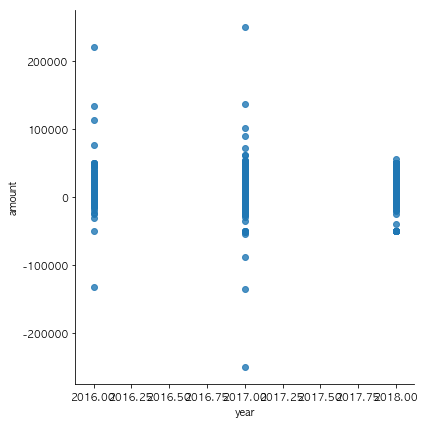

In [148]:
sns.lmplot(data=train, x="year", y="amount", fit_reg=False, size=6, aspect=1)

#### vilolinplot을 이용해 좀 더 정확하게 확인해보겠습니다 

In [242]:
train["temp"] = 1

/Users/PJS/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


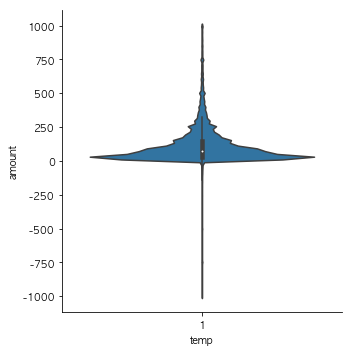

In [240]:
sns.catplot(data=train, x="temp", y="amount", kind="violin")

#### amount의 분포 범위는 넓은데 반해 분포 위치는 한쪽으로 편중되어 확인이 어렵습니다. 따라서 numpy의 percentile을 이용해 데이터가 차지하는 비율을 확인해보겠습니다 

In [269]:
percentage_99 = np.percentile(train["amount"], 99)
print(percentage_99)

715.0


In [270]:
percentage_98 = np.percentile(train["amount"], 98)
print(percentage_98)

550.0


#### amount의 최대값은 250000, 최소값은 -250000입니다
#### amount 값의 약 99%가 차지하는 위치의 값은 1335, 98%가 차지하는 위치의 값은 800입니다
#### 이는 대부분의 data가 1000이하에 위치하고 있음을 의미합니다. 따라서 1000 이상, -1000 이하의 값을 outlier로 간주하겠습니다

In [157]:
train = train.loc[(train["amount"] >= -1000) & (train["amount"] <= 1000)]

#### outlier를 제거하였습니다

### 2-2. Fill in null data
#### null data를 찾아 채워 넣습니다

In [87]:
train.isnull().sum()

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3345936
days_of_week          0
holyday               0
year                  0
month                 0
day                   0
hour                  0
minute                0
second                0
dtype: int64

In [88]:
train.loc[train["installments"].isnull(), "installments"] = 1

In [89]:
train.isnull().sum()

store_id        0
date            0
time            0
card_id         0
amount          0
installments    0
days_of_week    0
holyday         0
year            0
month           0
day             0
hour            0
minute          0
second          0
dtype: int64

#### intstallments의 null값은 일시불을 의미하기 때문에, 분할 값 1로 모두 채웠습니다

### 2-3. total
#### amount는 총액이 할부 단위로 계산한 금액입니다. 따라서 총액을 나타내는 total이라는 컬럼을 생성하겠습니다
#### total = amount * installments
#### total은 총 금액을 나타나내는 column

In [90]:
train["total"] = train["amount"] * train["installments"]

## 3. Data Analysis

#### 각각의 column을 분석하기에 앞서 column간의 correlation을 확인해보겠습니다

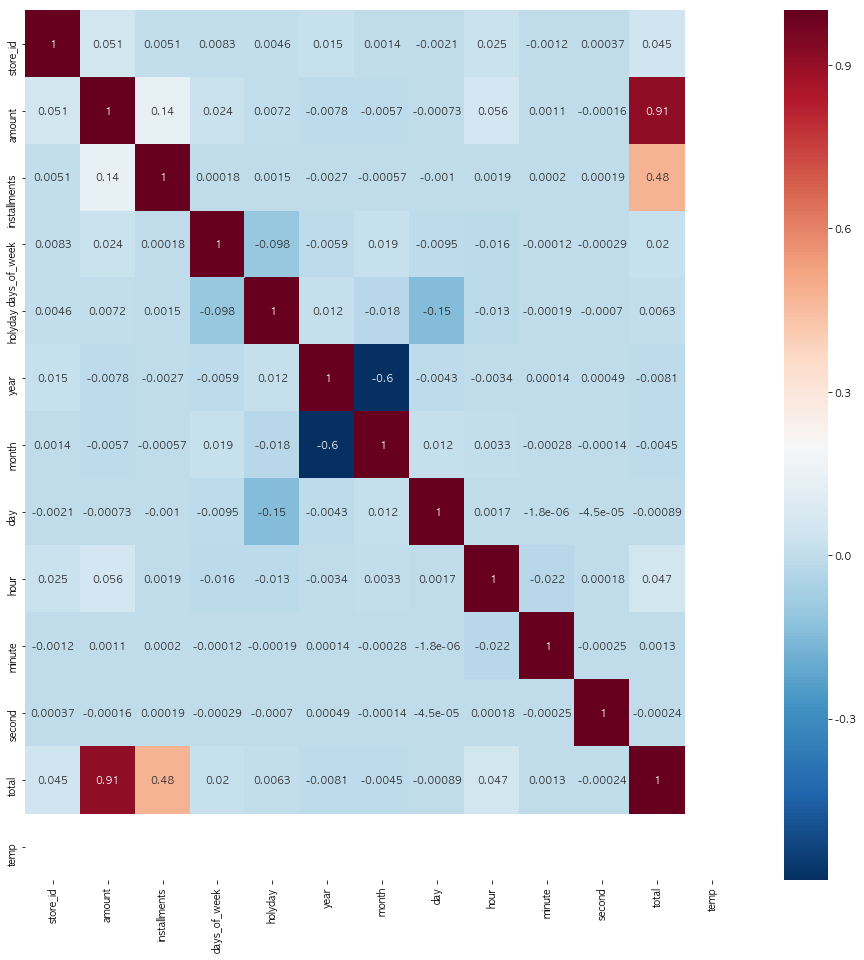

In [260]:
plt.figure(figsize=(16, 16))
sns.heatmap(train[train.columns].corr(), cmap="RdBu_r", annot=True)

### 3-1. store_id

### 3-1-1. 거래 기록 기준

#### store_id의 countplot을 확인해보겠습니다

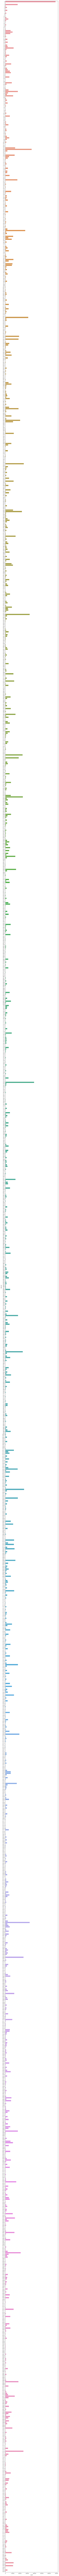

In [41]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 500)
sns.countplot(data=train, y="store_id")

#### store_id의 숨겨진 경향성을 확인하고자 하였지만, 따로 확인된 것은 없습니다
#### 가게 마다 거래 기록 count 편차가 심하게 난다는 것을 확인할 수 있습니다
#### store_id의 개수가 1799가 있기 때문에 countplot으로는 확인이 어렵습니다. data frame 형태로 거래 기록 상위 10개를 확인해보도록 하겠습니다

In [198]:
count_list = []
for i in range(1799):
    train_temp = train.loc[train["store_id"] == i]
    values = {"count" : train_temp.shape[0]}
    count_list.append(values)

In [199]:
count_list = pd.DataFrame.from_dict(count_list)
count_list = count_list.sort_values(by="count", ascending=False)
count_list.index.name = "store_id"

In [206]:
count_list.head(10)

,count
store_id,
0,68715
753,39217
105,35999
1342,33325
428,33281
221,31404
161,26108
1038,25694
323,25219


#### 거래 기록이 많은 기준으로 정렬 했을 때, 상위 10개의 가게를 확인했습니다
#### 가장 많은 거래 기록이 있는 store_id는 0이며, 68715(환불기록 포함)개의 거래가 있었습니다
#### 10번째로 거래 기록이 많은 store_id는 1366이며, 24940개의 거래 기록을 갖고 있습니다
#### 거래 기록 기준 상위 10개의 가게는 유동인구가 많은 곳에 위치해 접근성이 높거나, 충성도 높은 고객을 보유하고 있음을 예측할 수 있습니다

#### 다음으로 거래 기록 기준 하위 10개의 리스트를 확인해보겠습니다

In [234]:
count_list.tail(10)

,count
store_id,
951,0
617,0
1600,0
601,0
255,0
11,0
1681,0
1216,0
506,0


#### 카드 거래 기록 기준 하위 10개 리스트에는 2016-08-01부터 2018-07-31까지 카드 거래 기록이 단 한 건도 발생하지 않은 가게로 이루어져있습니다
#### 카드 거래 기록이 단 한 건도 발생하지 않은 가게의 수를 확인해보겠습니다

In [236]:
count_list_0 = count_list.loc[count_list["count"] == 0]
count_list_0.shape[0]

55

#### 기간 중 카드 거래 기록이 단 한 건도 발생하지 않은 가게는 총 55개가 있습니다

### 3-1-2. 매출액 기준

#### 다음으로 매출액 기준 상위 10개의 store_id를 확인해보겠습니다

In [224]:
total_list = []
for i in range(1799):
    train_temp = train.loc[train["store_id"] == i]
    values = {"total" : train_temp["total"].sum()}
    total_list.append(values)

In [225]:
total_list = pd.DataFrame.from_dict(total_list)
total_list = total_list.sort_values(by="total", ascending=False)
total_list.index.name = "store_id"

In [226]:
total_list.head(10)

,total
store_id,
753,9353275.0
1342,7392831.0
0,5318111.0
161,4624716.0
1076,3781650.0
1024,2962918.0
104,2960875.0
1209,2863403.0
597,2787632.0


#### 매출액이 가장 높은 store_id는 753으로 매출액은 9353275입니다
#### 10번째로 매출액이 높은 store_id는 105이며, 매출액은 2563178입니다. 가장 높은 매출액의 약 1/4로 비교적 큰 차이임을 확인할 수 있습니다
#### 거래기록 기준 상위 10개 리스트 중, 5개의 store_id(753, 1342, 0, 161, 105)가 매출액 기준 상위 10개의 리스트에도 포함되어 있음을 확인할 수 있습니다

#### 다음으로 매출액 기준 하위 10개의 리스트를 확인해보겠습니다

In [229]:
total_list.tail(10)

,total
store_id,
601,0.0
1354,0.0
454,0.0
1231,0.0
1530,0.0
1649,0.0
1216,0.0
1582,0.0
1681,0.0


#### 기간 중 카드 거래 기록이 단 한건도 발생하지 않은 가게가 55개 있었기 때문에, 예상대로 매출액 기준 리스트의 하위 10개 가게의 매출액은 모두 0입니다

### 3-2. date & time

### 3-2-1. year

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


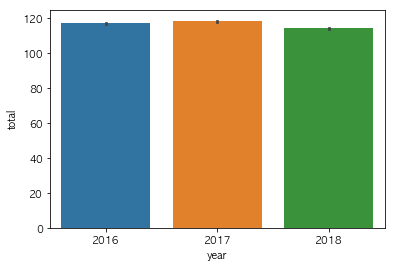

In [246]:
sns.barplot(data=train, x="year", y="total")

#### 연도별 평균 총액을 확인했습니다. 2016년과 2018년은 1년 단위로 집계되지 않은 data이기에 barplot을 이용해 거래 기록 총액의 평균값(total/count)을 이용했습니다
#### 2017년 까지 경제 활동은 다소 올라갔지만, 2018년 부터 경제 활동이 다소 줄어든 것을 확인할 수 있습니다

In [247]:
train_2016 = train.loc[train["year"]==2016]
train_2017 = train.loc[train["year"]==2017]
train_2018 = train.loc[train["year"]==2018]

total_2016 = train_2016["total"].sum()
total_2017 = train_2017["total"].sum()
total_2018 = train_2018["total"].sum()

count_2016 = train_2016.shape[0]
count_2017 = train_2017.shape[0]
count_2018 = train_2018.shape[0]

print(total_2016)
print(total_2017)
print(total_2018)
print("-------------")
print(count_2016)
print(count_2017)
print(count_2018)
print("-------------")
print(total_2016/count_2016)
print(total_2017/count_2017)
print(total_2018/count_2018)

52396492.0
188527907.0
145441161.0
-------------
447638
1592634
1271139
-------------
117.05103677525143
118.37491036860949
114.41798339914045


### 3-2-2. month

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


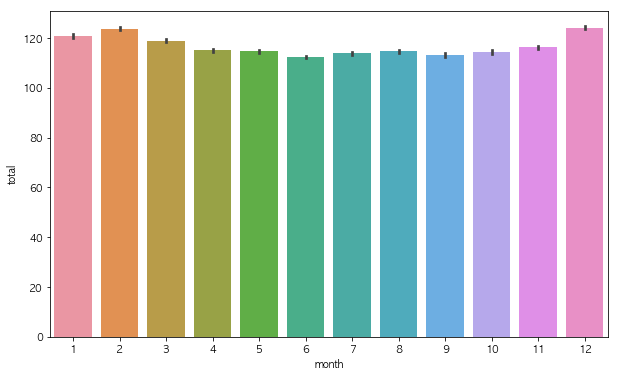

In [251]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 6)
sns.barplot(data=train, x="month", y="total")

#### 월별 평균 총액을 확인했습니다
#### 12월이 가장 높았고, 6월이 가장 낮았습니다
#### 12월은 송년회 및 연말 할인이 빈번하기 때문에 경제 활동이 가장 많다고 예측해 볼 수 있습니다

### 3-2-3. day

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


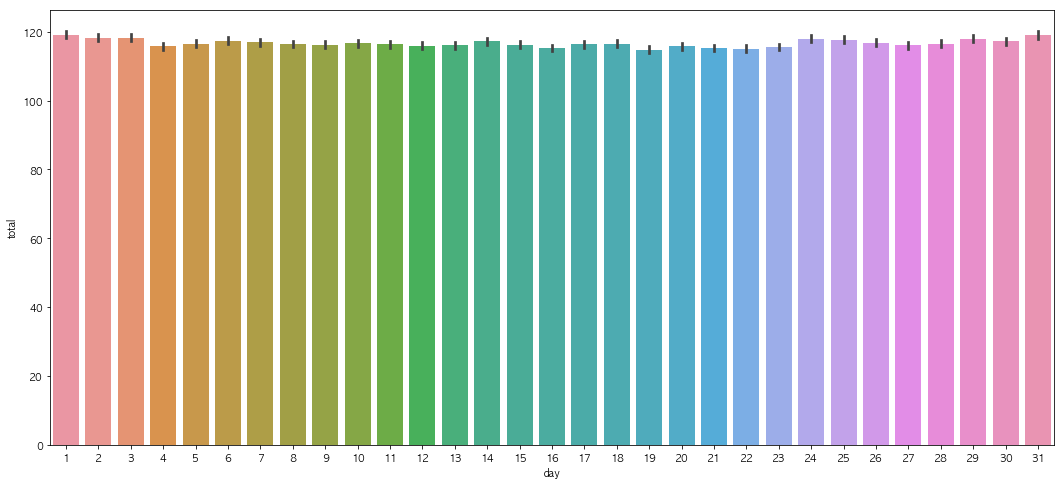

In [252]:
figure, ax = plt.subplots()
figure.set_size_inches(18, 8)
sns.barplot(data=train, x="day", y="total")

#### 24일부터 31일까지 날짜별 평균 매출 총액이 가장 높습니다
#### 이는 경제 활동 인구의 급여가 24일 이후에 들어오는 것과 연결되어 있기 때문이라고 판단됩니다

### 3-2-4. days_of_week

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


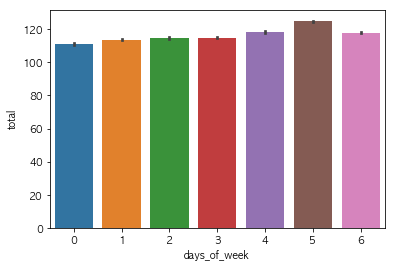

In [256]:
sns.barplot(data=train, x="days_of_week", y="total")

#### 요일별 평균 매출 총액을 확인했습니다
#### 월요일(0)부터 토요일(6)까지 꾸준하게 상승해 토요일에 가장 많은 매출일 일어나는 것을 확인했습니다
#### 토요일과 일요일 모두 주말이지만, 일요일은 토요일에 비해 크게 줄었습니다

#### 요일별 평균 매출 총액을 통해 주말에 경제 활동이 많은 것을 확인했습니다
#### holyday를 기준으로 요일별 매출 총액을 다시 확인해보겠습니다

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


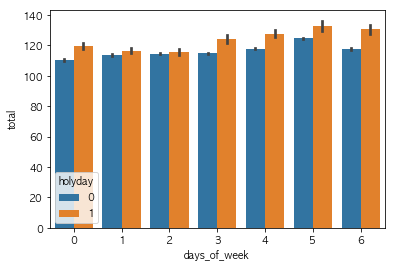

In [257]:
sns.barplot(data=train, x="days_of_week", y="total", hue="holyday")

#### 예측대로 평일에 비해 공휴일에 평균 매출 총액이 높은 것을 확인할 수 있습니다

### 3-2-5. hour

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


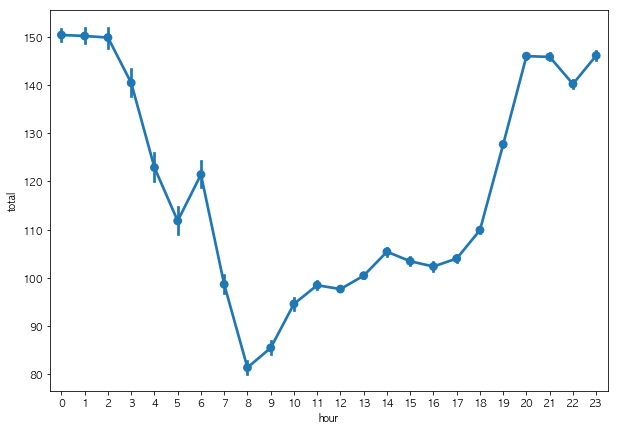

In [261]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total")

#### 시간별 매출 총액 평균을 pointplot으로 확인했습니다
#### 퇴근 시간인 오후 6시 부터 급격히 상승하기 시작하면서 자정부터 새벽 2시까지 매출액이 가장 높고, 이후로 점차 줄어들면서 오전 8시까지 점차적으로 하락하는 것을 확인할 수 있습니다

#### 요일에 따라 시간별 매출 총액 평균을 확인해보겠습니다

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


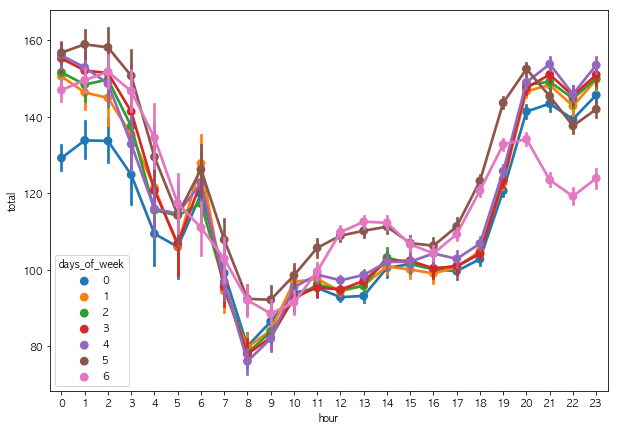

In [263]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total", hue="days_of_week")

#### 일욜일(6)을 제외한 모든 요일에 대해서 시간별 매출 양상이 비슷하게 나타나고 있습니다
#### 특징적인 것으로는 일요일은 비교적 오후 8시 이후부터 매출액이 감소하고 있습니다. 다음날 출근을 위해 외출을 자제하는 성향에 기인하는 것으로 예측할 수 있습니다
#### 그리고 다른 요일에 비해 월요일은 자정부터 새벽 2시까지의 매출 총액이 다른 요일에 비해 비교적 적습니다. 월요일은 비교적 경제 활동 인구가 빨리 귀가하는 것이라고 판단됩니다

#### 다음으로 공휴일/평일 기준으로 시간별 매출 총액을 확인해보겠습니다

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


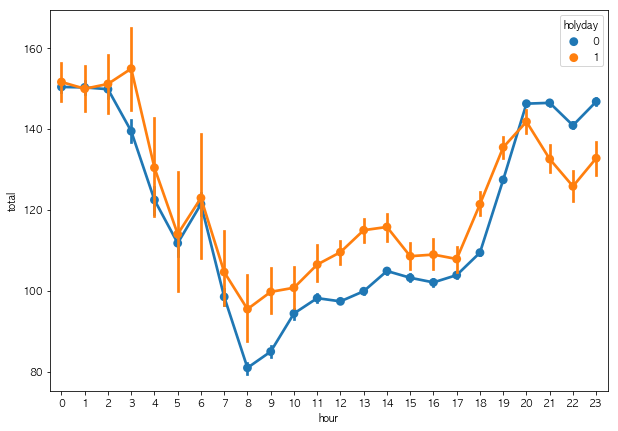

In [264]:
plt.figure(figsize=(10, 7))
sns.pointplot(data=train, x="hour", y="total", hue="holyday")

#### 공휴일의 매출 총액이 평일의 매출 총액보다 전체적으로 높게 위치하고 있음을 알 수 있습니다
#### 뿐만 아니라 공휴일의 시간별 매출 총액의 편차는 평일보다 크게 나타납니다. 이는 특히 새벽시간에 그 편차가 크게 나타나고 있는데, 다음날이 쉬는 날인지 여부에 따라 그 값의 차이가 크게 나타나는 것이라고 예측합니다. 이를 확인하기 위해 다음날이 주말 또는 휴일인지를 확인하는 column을 추가해 검증해보도록 하겠습니다

In [ ]:
train.loc[(train["days_of_week"] == 4) | (train["days_of_week"] == 5) | (train)]

In [ ]:
train.loc[train["days_of_week"]]

In [1]:
train.loc[train["holyday"] == 1, "yesterday"] = train.loc[train["holyday"] == 1, train["day"] - 1]

NameError: name 'train' is not defined

### 3-3. amount, total

### 3-3-1 amount

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


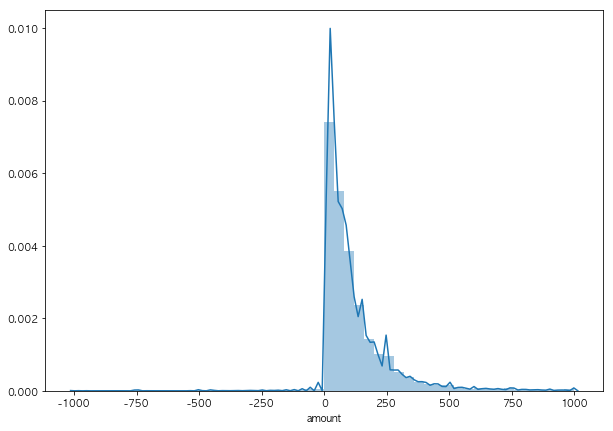

In [267]:
plt.figure(figsize=(10, 7))
sns.distplot(train["amount"])

### 3-3-2 total

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


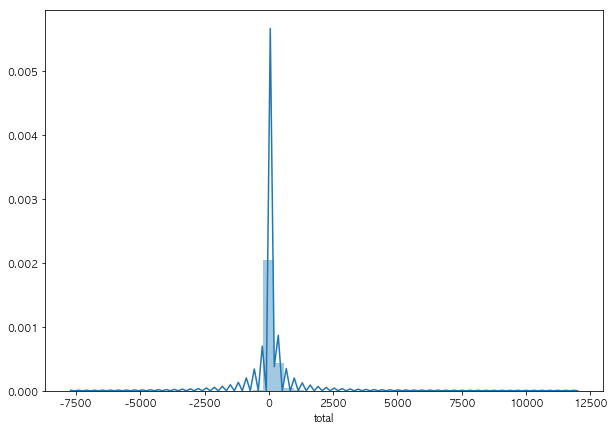

In [268]:
plt.figure(figsize=(10, 7))
sns.distplot(train["total"])